In [8]:
import numpy as np
from PIL import Image
import cv2

In [33]:

path = r"C:\Users\kyuha\PycharmProjects\Bioinformatics_RESTAPI\scripts\microscopic_sample.jpg"
image = Image.open(path)
image = np.array(image.convert("RGB"))
image

array([[[  4, 143,  18],
        [  7, 112,   7],
        [  4,  90,   0],
        ...,
        [253, 253, 253],
        [255, 255, 255],
        [255, 255, 255]],

       [[ 11, 159,   9],
        [  0, 119,  11],
        [  8,  87,   4],
        ...,
        [252, 252, 252],
        [254, 254, 254],
        [255, 255, 255]],

       [[  0, 148,   0],
        [  0, 126,  11],
        [  0,  94,   0],
        ...,
        [250, 250, 250],
        [254, 254, 254],
        [255, 255, 255]],

       ...,

       [[250, 250, 250],
        [245, 245, 245],
        [237, 237, 237],
        ...,
        [250, 250, 250],
        [254, 254, 254],
        [255, 255, 255]],

       [[254, 254, 254],
        [251, 251, 251],
        [247, 247, 247],
        ...,
        [252, 252, 252],
        [254, 254, 254],
        [255, 255, 255]],

       [[255, 255, 255],
        [254, 254, 254],
        [252, 252, 252],
        ...,
        [253, 253, 253],
        [255, 255, 255],
        [255, 255, 255]]

In [15]:
    # Avoid log(0) by setting zero values to a small number
epsilon = 1e-6  # Small value to prevent log issues

# Compute Optical Density (OD)
od_image = -np.log10((image.astype(np.float32) + epsilon) / 255)

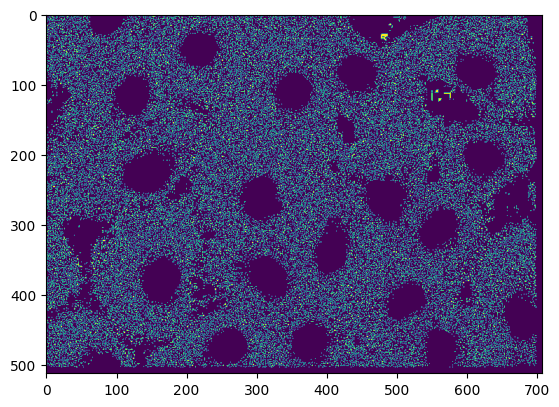

In [30]:
od_gray = np.mean(od_image, axis=-1)
threshold=5
binary_mask = (od_gray > threshold)
plt.imshow((od_gray > threshold).astype(np.uint8) * 255 )

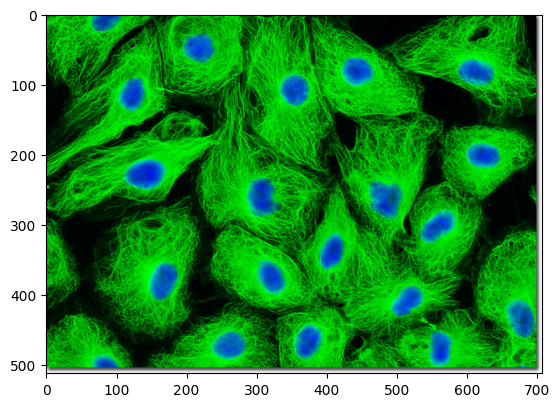

In [34]:
from matplotlib import pyplot as plt
plt.imshow(image)

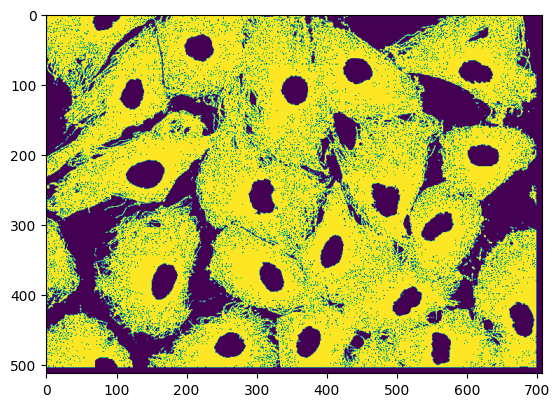

In [35]:
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  # Convert to OpenCV BGR format

# Convert to HSV and LAB color spaces for better blue detection
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

# Create masks based on optimized color thresholds
mask_hsv = cv2.inRange(hsv, np.array([60, 50, 50]), np.array([87, 255, 255]))
mask_lab = cv2.inRange(lab, np.array([128, 127, 128]), np.array([200, 128, 128]))

plt.imshow(mask_hsv)

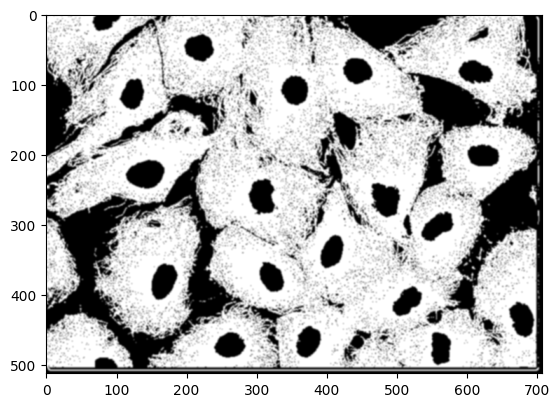

In [42]:
# Combine masks to enhance detection
combined_mask = cv2.bitwise_or(mask_hsv, mask_lab)

plt.imshow(combined_mask)
 # Apply Gaussian blur to reduce noise
blurred = cv2.GaussianBlur(combined_mask, (5, 5), 0)

# Use adaptive thresholding for dynamic segmentation
adaptive_thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                        cv2.THRESH_BINARY, 11, 2)
# Apply morphological operations to refine detection
kernel = np.ones((3, 3), np.uint8)
processed_mask = cv2.morphologyEx(adaptive_thresh, cv2.MORPH_CLOSE, kernel, iterations=2)

plt.imshow(blurred, cmap="gray")

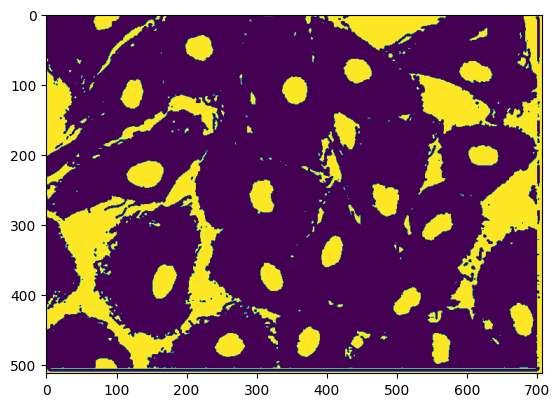

In [61]:
_, binary_mask = cv2.threshold(blurred, 50, 255, cv2.THRESH_BINARY)
contours, _ = cv2.findContours(~binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
plt.imshow(~binary_mask)

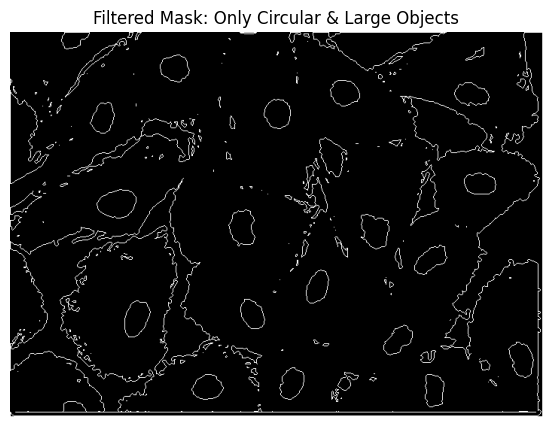

In [62]:
# Create a mask with only the selected circular objects
circular_mask = np.zeros_like(binary_mask)
cv2.drawContours(circular_mask, contours, -1, (255))  # Fill selected objects with white

# Display the filtered mask with only circular objects
plt.figure(figsize=(10, 5))
plt.imshow(circular_mask, cmap="gray")
plt.title("Filtered Mask: Only Circular & Large Objects")
plt.axis("off")
plt.show()

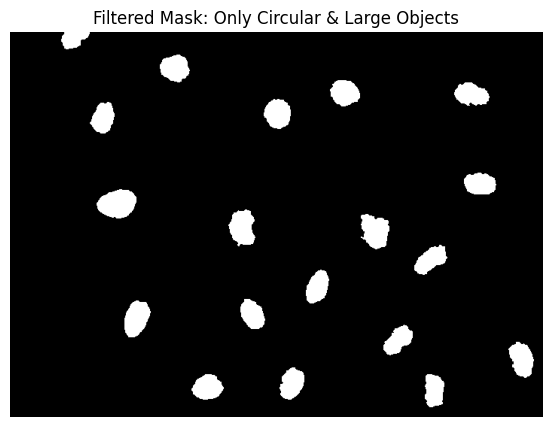

In [63]:
min_area = 500  # Minimum area threshold to keep objects
circularity_threshold = 0.5  # Circularity threshold to detect circular objects

# List to store circular objects that are big enough
circular_objects = []

for contour in contours:
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)

    if perimeter == 0 or area < min_area:  # Skip very small objects
        continue

    # Compute circularity: 4π * Area / Perimeter^2
    circularity = (4 * np.pi * area) / (perimeter ** 2)

    # Keep only objects that are circular and large enough
    if circularity >= circularity_threshold:
        circular_objects.append(contour)

# Create a mask with only the selected circular objects
circular_mask = np.zeros_like(binary_mask)
cv2.drawContours(circular_mask, circular_objects, -1, (255), thickness=cv2.FILLED)  # Fill selected objects with white

# Display the filtered mask with only circular objects
plt.figure(figsize=(10, 5))
plt.imshow(circular_mask, cmap="gray")
plt.title("Filtered Mask: Only Circular & Large Objects")
plt.axis("off")
plt.show()